In [2]:
import torch

from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

import datamanip.plots
import importlib
from datamanip.datasetmanip.three_five_dataset import ThreeFiveDataset

importlib.reload(datamanip.plots)



<module 'datamanip.plots' from 'C:\\Users\\pavel\\PycharmProjects\\ADES-reliability-estimation\\src\\datamanip\\plots.py'>

In [3]:

from filepath import *
from datamanip.plots import plot_rel_distribution, generate_matrix
from models.GAT import GAT#, GCN, SimpleMPNN
from train_eval.train import train
from train_eval.evaluate import evaluate



In [4]:
# Number of epochs to train the model
NUM_EPOCHS = 100

# Dropout rate for the model to prevent overfitting
DROPOUT_RATE = 0.3

# Learning rate for the optimizer
LEARNING_RATE = 0.0005

# Threshold for classifying reliability
THRESHOLD = 0.97

# Number of features for each node in the graph
NODE_FEATURES = 5

# Number of epochs to wait for improvement before early stopping
PATIENCE = 20

# Flag to indicate whether to use only one timestamp
ONE_TIMESTAMP = False

NUM_BINS = 0

In [5]:
data_list = ThreeFiveDataset(root=dataset_path, load_binary=False)

In [6]:
# Split into training and testing data
train_data_list, test_data_list  = train_test_split(data_list, test_size=0.2, random_state=42)

# Further split training data into training and validation
train_data_list, val_data_list = train_test_split(train_data_list, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2 validation split

# Create DataLoaders
train_loader = DataLoader(train_data_list, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data_list, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data_list, batch_size=16, shuffle=False)

print(f"Training samples: {len(train_data_list)}")
print(f"Validation samples: {len(val_data_list)}")
print(f"Test samples: {len(test_data_list)}")


Training samples: 100641
Validation samples: 33547
Test samples: 33548


In [91]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GAT(input_dim=NODE_FEATURES, hidden_dim=64, output_dim=NUM_BINS, dropout_rate=DROPOUT_RATE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()

In [92]:
train_config = {
    "num_epochs": NUM_EPOCHS,
    "patience": PATIENCE,
    "device": device,
    "criterion": criterion,
    "optimizer": optimizer,
}

In [94]:
train(model, train_loader, val_loader, train_config, model_checkpoints_path + "best_model_GAT_MCC.pth")

Epoch 1/100, Train Loss: 0.9653
Epoch 1/100, Validation Loss: 1.0319
Best model updated based on validation loss.
Epoch 2/100, Train Loss: 0.9359
Epoch 2/100, Validation Loss: 1.1493
No improvement in validation loss for 1 epoch(s).
Epoch 3/100, Train Loss: 0.9137
Epoch 3/100, Validation Loss: 1.1266
No improvement in validation loss for 2 epoch(s).
Epoch 4/100, Train Loss: 0.8904
Epoch 4/100, Validation Loss: 1.0011
Best model updated based on validation loss.
Epoch 5/100, Train Loss: 0.8750
Epoch 5/100, Validation Loss: 1.3819
No improvement in validation loss for 1 epoch(s).
Epoch 6/100, Train Loss: 0.8778
Epoch 6/100, Validation Loss: 1.3750
No improvement in validation loss for 2 epoch(s).
Epoch 7/100, Train Loss: 0.8654
Epoch 7/100, Validation Loss: 1.1061
No improvement in validation loss for 3 epoch(s).
Epoch 8/100, Train Loss: 0.8650
Epoch 8/100, Validation Loss: 1.4647
No improvement in validation loss for 4 epoch(s).
Epoch 9/100, Train Loss: 0.8554
Epoch 9/100, Validation Lo

In [95]:
# Load the best model after training
model.load_state_dict(torch.load(model_checkpoints_path + "best_model_GAT_MCC.pth", weights_only=True))

<All keys matched successfully>

In [96]:
true_values, predicted_values, accuracy = evaluate(device, model, test_loader, model_checkpoints_path + "best_model_GAT_MCC.pth")

GAT(
  (conv1): GATConv(5, 64, heads=1)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GATConv(64, 32, heads=1)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=32, out_features=8, bias=True)
)
[np.int64(4), np.int64(3), np.int64(2), np.int64(3), np.int64(4), np.int64(0), np.int64(3), np.int64(0), np.int64(0), np.int64(1)]
[np.int64(4), np.int64(2), np.int64(2), np.int64(2), np.int64(3), np.int64(0), np.int64(2), np.int64(0), np.int64(0), np.int64(1)]
Accuracy: 0.6758


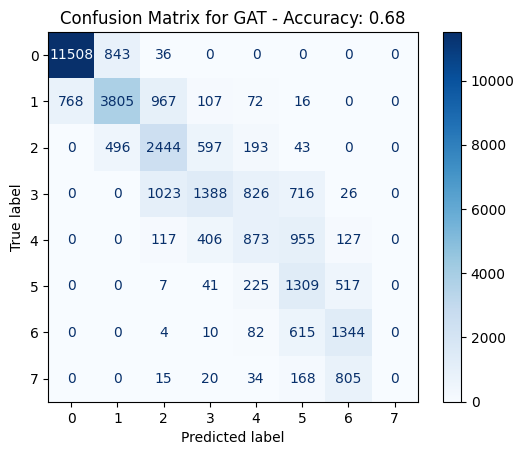

In [97]:
generate_matrix(true_values, predicted_values, accuracy, "GAT")